# Background 
This code implements a spiking neural net with conductance in input. the following equations govern the dynamic of the network. 


### notes about the implementation 
-  both input and recurrent weight are combined into 1 kernel matrix 


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.cm as cm

import numpy as np
import tensorflow as tf

import collections
import hashlib
import numbers
from datetime import datetime
from pathlib import Path
import os

from tensorflow.python.eager import context
from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.layers import base as base_layer
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import partitioned_variables
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import tensor_array_ops
from tensorflow.python.ops import variable_scope as vs
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.util import nest
from tensorflow.contrib.rnn.python.ops.core_rnn_cell import _Linear
from tensorflow.contrib import slim
from matplotlib.colors import LinearSegmentedColormap

import kernl_rnn_cell


first testing the code on a constant input 

rnn/kernl_rnn_cell/temporal_filter:0 [0.00940619 0.00106241 0.00964763 0.00933592 0.00061415 0.00988355
 0.00829653 0.00085785 0.00415083 0.00861524]
rnn/kernl_rnn_cell/sensitivity_tensor:0 [[ 0.29702562  0.1397363  -0.3174863   0.5205499   0.2385642  -0.24823862
  -0.18179637 -0.32399464  0.22756487  0.4143247 ]
 [-0.2801039  -0.3835004  -0.5244043   0.03490257 -0.41701287  0.35053295
  -0.46385175  0.50594485 -0.11983052  0.30887747]
 [-0.4371763  -0.11484757 -0.0566861  -0.28971705 -0.38496792 -0.38870978
   0.3697139   0.5013987  -0.32842207 -0.43361688]
 [-0.22306219 -0.14021623 -0.13150957  0.2328847   0.08739483  0.05485314
  -0.21720093  0.25175053  0.01333976 -0.04165733]
 [ 0.49053657 -0.1448018   0.11352211 -0.34050024 -0.09769467  0.54311633
   0.07005912 -0.2830443   0.4867165  -0.28668118]
 [-0.08973786 -0.34446368  0.32320994  0.38979208  0.53503096  0.11077601
   0.25611216  0.33613753 -0.14003521  0.20886016]
 [-0.21469966 -0.29703125  0.3892035  -0.16166764  0.0552962

4.8335138e-11

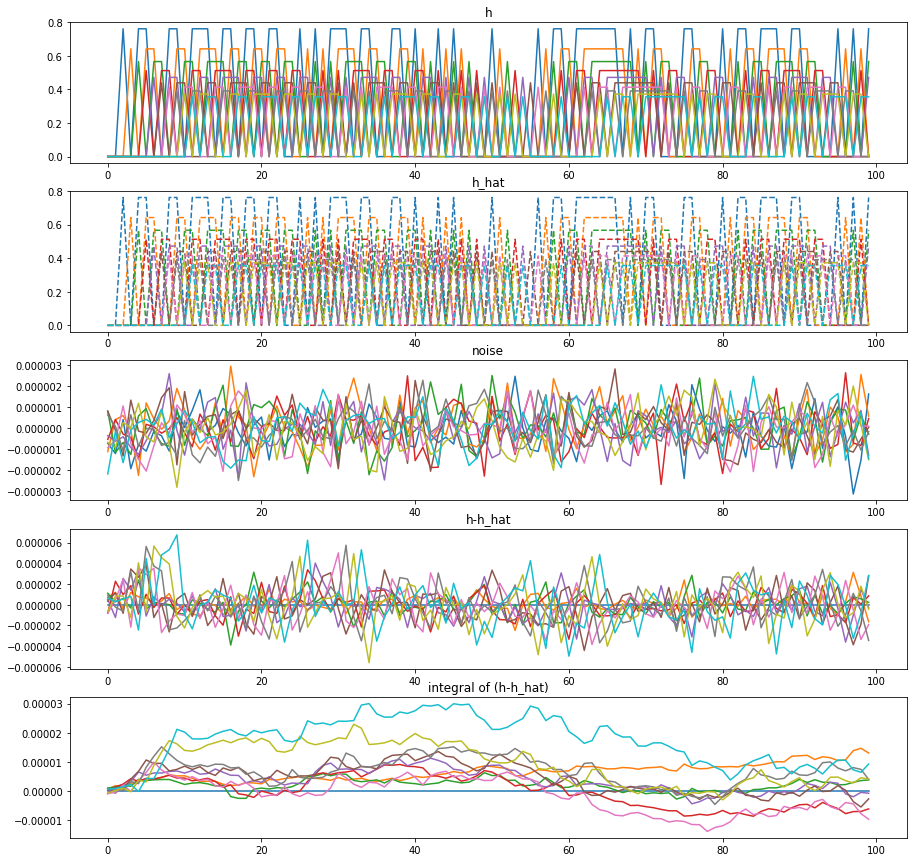

In [2]:
tf.reset_default_graph()
batch_size = 1
sequence_length = 100
num_inputs=1
num_units=10
input_spikes=np.random.randint(2,size=[batch_size,sequence_length,num_inputs])
#input_spikes=0.01*np.ones([batch_size,sequence_length,num_inputs])
tf.reset_default_graph()

tf_input_values = tf.constant(input_spikes, dtype=tf.float32)
kernl_rnn = kernl_rnn_cell.kernl_rnn_cell(num_units=num_units,
                                          num_inputs=num_inputs,
                                          state_is_tuple=True,
                                          output_is_tuple=True,
                                          time_steps=sequence_length,
                                          noise_param=1e-6,
                                          activation='tanh',
                                         kernel_initializer=tf.initializers.identity)

outputs, state = tf.nn.dynamic_rnn(cell=kernl_rnn, dtype=tf.float32, inputs=tf_input_values)
trainables=tf.trainable_variables()
find_joing_index = lambda x, name_1,name_2 : [a and b for a,b in zip([np.unicode_.find(k.name, name_1)>-1 for k in x] ,[np.unicode_.find(k.name, name_2)>-1 for k in x])].index(True)
    # find trainable parameters for kernl 

kernl_temporal_filter_index= find_joing_index(trainables,'kernl','temporal_filter')
kernl_sensitivity_tensor_index= find_joing_index(trainables,'kernl','sensitivity_tensor')
kernl_tensor_training_indices=np.asarray([kernl_sensitivity_tensor_index,kernl_temporal_filter_index],dtype=np.int)
kernl_tensor_trainables= [trainables[k] for k in kernl_tensor_training_indices]
kernl_loss_state_prediction=tf.losses.mean_squared_error(tf.subtract(state.h_hat, state.h),tf.matmul(state.Theta,trainables[kernl_sensitivity_tensor_index]))    


cell_outputs=[]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    output_run , state_run,kernl_loss = sess.run([outputs, state,kernl_loss_state_prediction])

    variables_names =[v.name for v in tf.global_variables()]
    values = sess.run(variables_names)
    for k,v in zip(variables_names, values):
        print(k, v) 
plt.figure(figsize=[15,15])
ax=plt.subplot(5,1,1)
ax.plot(output_run.h.squeeze(axis=0))
ax.set_title('h')
ax=plt.subplot(5,1,2)
ax.plot(output_run.h_hat.squeeze(axis=0),'--')
ax.set_title('h_hat')
ax=plt.subplot(5,1,3)
ax.plot(output_run.psi.squeeze(axis=0))
ax.set_title('noise')
ax=plt.subplot(5,1,4)
ax.plot(output_run.h.squeeze(axis=0)-output_run.h_hat.squeeze(axis=0))
ax.set_title('h-h_hat')
ax=plt.subplot(5,1,5)
ax.plot(np.cumsum(output_run.h.squeeze(axis=0)-output_run.h_hat.squeeze(axis=0),axis=0))
ax.set_title('integral of (h-h_hat)')
kernl_loss

next we create a recurrent version to verify the functionality 

### computation graph for learning $M$ and $K(\tau)$

In the original version of kernl implemented in rnn, the value of h was a continues function in time, and the perturbation could accumulate throughout a trial, which made the calculation of difference between perturbed and non-perturbed h straightforward. However in the spiking network here, there is a complication with the value of v_mem being discontinuous. how can we aleviate this problem. based on the example about, we can see that if we integrate the difference between them, we get a smoother function to calculate gradients from. we first try to optimize based on final difference between the integrals.  

In [3]:
tensor_learning_rate=1e-3
training_steps = 5000
batch_size = 25
display_step = 200
grad_clip=200

sequence_length = 100
num_inputs=1
num_units=100
noise_param=1e-5
#input_spikes=1.0*np.ones([batch_size,sequence_length,num_inputs])

tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default():
    # define the network
    X = tf.placeholder("float", [None, sequence_length, num_inputs])
    kernl_rnn = kernl_rnn_cell.kernl_rnn_cell(num_units=num_units,
                                          num_inputs=num_inputs,
                                          state_is_tuple=True,
                                          output_is_tuple=True,
                                          time_steps=sequence_length,
                                          noise_param=0.1,
                                          activation="relu",
                                          kernel_initializer=tf.initializers.identity)

    outputs, state = tf.nn.dynamic_rnn(cell=kernl_rnn, dtype=tf.float32, inputs=X)
    trainables=tf.trainable_variables()
    find_joing_index = lambda x, name_1,name_2 : [a and b for a,b in zip([np.unicode_.find(k.name, name_1)>-1 for k in x] ,[np.unicode_.find(k.name, name_2)>-1 for k in x])].index(True)
    # find trainable parameters for kernl 

    kernl_temporal_filter_index= find_joing_index(trainables,'kernl','temporal_filter')
    kernl_sensitivity_tensor_index= find_joing_index(trainables,'kernl','sensitivity_tensor')
    kernl_tensor_training_indices=np.asarray([kernl_sensitivity_tensor_index,kernl_temporal_filter_index],dtype=np.int)
    kernl_tensor_trainables= [trainables[k] for k in kernl_tensor_training_indices]
    kernl_loss_state_prediction=tf.losses.mean_squared_error(tf.subtract(state.h_hat, state.h),tf.matmul(state.Theta,trainables[kernl_sensitivity_tensor_index]))    
    kernl_tensor_optimizer = tf.train.RMSPropOptimizer(learning_rate=tensor_learning_rate)
    kernl_tensor_grads=tf.gradients(ys=kernl_loss_state_prediction,xs=kernl_tensor_trainables)
    kernl_tensor_grad_and_vars=list(zip(kernl_tensor_grads,kernl_tensor_trainables))
    kernl_tensor_train_op=kernl_tensor_optimizer.apply_gradients(kernl_tensor_grad_and_vars)
    init = tf.global_variables_initializer()    
    
    ##################
    # SUMMARIES ######
    ##################

        # kernl sensitivity tensor 
    tf.summary.histogram('kernl_sensitivity_tensor_grad',kernl_tensor_grads[0]+1e-10)
    tf.summary.histogram('kernl_sensitivity_tensor',trainables[kernl_sensitivity_tensor_index]+1e-10)
        # kernl temporal filter 
    tf.summary.histogram('kernl_temporal_filter_grad',kernl_tensor_grads[1]+1e-10)
    tf.summary.histogram('kernl_temporal_filter',trainables[kernl_temporal_filter_index]+1e-10)
        # kernl loss 
    tf.summary.scalar('kernl_loss_state_prediction',kernl_loss_state_prediction+1e-10)
        # kernl senstivity tensor and temporal filter 
    tf.summary.image('kernl_sensitivity_tensor',tf.expand_dims(tf.expand_dims(trainables[kernl_sensitivity_tensor_index],axis=0),axis=-1))
    tf.summary.image('kernl_sensitivity_tensor_grad',tf.expand_dims(tf.expand_dims(kernl_tensor_grads[0],axis=0),axis=-1))
    tf.summary.image('kernl_temporal_filter',tf.expand_dims(tf.expand_dims(tf.expand_dims(trainables[kernl_temporal_filter_index],axis=0),axis=-1),axis=-1))
    tf.summary.image('kernl_temporal_filter_grad',tf.expand_dims(tf.expand_dims(tf.expand_dims(kernl_tensor_grads[1],axis=0),axis=-1),axis=-1))
    kernl_tensor_merged_summary_op=tf.summary.merge_all()
    
     
    saver = tf.train.Saver()

In [4]:
log_dir = "/home/eghbal/MyData/KeRNL/logs/kernl_rnn_cell/base_uniform_gc_%.1e_eta_m_%.1e_batch_%.1e_units_%.1e_seqlen_%.1e_run_%s" %(grad_clip,tensor_learning_rate,batch_size,num_units,sequence_length, datetime.now().strftime("%Y%m%d_%H%M"))
Path(log_dir).mkdir(exist_ok=True, parents=True)
filelist = [ f for f in os.listdir(log_dir) if f.endswith(".local") ]
for f in filelist:
    os.remove(os.path.join(log_dir, f))

In [5]:
tb_writer = tf.summary.FileWriter(log_dir,graph)
with tf.Session(graph=graph) as sess:
    sess.run(init)
    for step in range(1,training_steps+1):
        input_spikes=np.random.uniform(low=0.0,high=1.0,size=[batch_size,sequence_length,num_inputs])
        kernl_tensor_train,kernl_loss_state=sess.run([kernl_tensor_train_op,kernl_loss_state_prediction], feed_dict={X: input_spikes})        
        # run summaries 
        kernl_tensor_merged_summary=sess.run(kernl_tensor_merged_summary_op, feed_dict={X: input_spikes})
        tb_writer.add_summary(kernl_tensor_merged_summary, global_step=step)
        
       
        if step % display_step==0 or step==1 : 
            # get batch loss and accuracy 
            print('Step: {}, keRNL tensor Loss {:.3f},'.format(step + 1, kernl_loss_state))

     

Step: 2, keRNL tensor Loss 1.026,
Step: 201, keRNL tensor Loss 0.400,
Step: 401, keRNL tensor Loss 0.337,
Step: 601, keRNL tensor Loss 0.346,
Step: 801, keRNL tensor Loss 0.326,
Step: 1001, keRNL tensor Loss 0.336,
Step: 1201, keRNL tensor Loss 0.337,
Step: 1401, keRNL tensor Loss 0.330,
Step: 1601, keRNL tensor Loss 0.328,
Step: 1801, keRNL tensor Loss 0.338,
Step: 2001, keRNL tensor Loss 0.316,
Step: 2201, keRNL tensor Loss 0.316,
Step: 2401, keRNL tensor Loss 0.344,
Step: 2601, keRNL tensor Loss 0.333,
Step: 2801, keRNL tensor Loss 0.340,
Step: 3001, keRNL tensor Loss 0.327,
Step: 3201, keRNL tensor Loss 0.330,
Step: 3401, keRNL tensor Loss 0.339,
Step: 3601, keRNL tensor Loss 0.328,
Step: 3801, keRNL tensor Loss 0.325,
Step: 4001, keRNL tensor Loss 0.362,
Step: 4201, keRNL tensor Loss 0.328,
Step: 4401, keRNL tensor Loss 0.319,
Step: 4601, keRNL tensor Loss 0.336,
Step: 4801, keRNL tensor Loss 0.320,
Step: 5001, keRNL tensor Loss 0.334,
